In [6]:
import sys
from time import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.feature import StandardScaler

In [3]:
def extract_label(fields):
    label = (fields[-1])
    return float(label)

def extract_features(fields,categoriesMap,featureEnd):
    categoryIdx = categoriesMap[fields[3]]
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    numericalFeatures = [convert_float(field) for field in fields[4:featureEnd]]
    return np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=='?' else float(x))


In [4]:
def PrepareData(sc):
    global Path
    if sc.master[0:5]=='local':
       Path = "file:/home/hadoop/pythonwork/data/stumbleupon" 
    else:
       Path = "hdfs:/user/hduser/MovieRecom/stumbleupon" 
    
    print 'data loading..'
    rawDataWithHeader = sc.textFile(Path+'/train.tsv')
    header = rawDataWithHeader.first()
    rawData = rawDataWithHeader.filter(lambda x:x != header)
    rData = rawData.map(lambda x: x.replace("\"",""))
    lines = rData.map(lambda x:x.split("\t"))
    print str(lines.count())
    #-----------construct the training data RDD[LabeledPoint]
    print "Before Normalzation.. \n"
    categoriesMap = lines.map(lambda fields:fields[3])\
                         .distinct().zipWithIndex().collectAsMap()
    labelRDD = lines.map(lambda r: extract_label(r))
    featureRDD = lines.map(lambda r: extract_features(r, categoriesMap, len(r)-1)) 
    for i in featureRDD.first():
        print (str(i)+","),
    print "\n"+"After Normalzation.. \n"
    stdScalar = StandardScaler(withMean=True, withStd=True).fit(featureRDD)
    #print type(stdScalar)
    ScalerFeatureRDD = stdScalar.transform(featureRDD)
    for i in ScalerFeatureRDD.first():
        print (str(i)+","),
    labelpoint = labelRDD.zip(ScalerFeatureRDD)
    labelpointRDD = labelpoint.map(lambda r: LabeledPoint(r[0], r[1]))
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print('\n'+'trainData size:'+str(trainData.count())+ 
          ', validData size:'+str(validationData.count())+
          ', testData size:'+str(testData.count()))
    return (trainData, validationData, testData)        

In [7]:
(trainData, validationData, testData) = PrepareData(sc)
trainData.persist()
validationData.persist()
testData.persist()

data loading..
7395
Before Normalzation.. 

0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.789131, 2.055555556, 0.676470588, 0.205882353, 0.047058824, 0.023529412, 0.443783175, 0.0, 0.0, 0.09077381, 0.0, 0.245831182, 0.003883495, 1.0, 1.0, 24.0, 0.0, 5424.0, 170.0, 8.0, 0.152941176, 0.079129575, 
After Normalzation.. 

-0.446421204794, 2.72073665645, -0.204182210579, -0.220526884579, -0.0648775723926, -0.270999069693, -0.680752790425, -0.101894690972, -0.028494000387, -0.201654052319, -0.232727977095, -0.0991499193088, -0.0232621058984, -0.381813223243, 1.1376473365, -0.0819355716929, 1.02513981289, -0.0558635644254, -0.468893253129, -0.354305326308, -0.317535217236, 0.33845079824, 0.0, 0.828822173315, -0.147268943346, 0.229639823578, -0.141625969099, 0.790238049918, 0.717194729453, -0.297996816496, -0.20346257793, -0.0329672096969, -0.0487811297558, 0.940069975117, -0.108698488525, -0.278820782314, 
trainData size:5913, validData size:742, testData size:740


PythonRDD[38] at RDD at PythonRDD.scala:48

In [8]:
def evaluateModel(model, validationData):    
    score = model.predict(validationData.map(lambda p: p.features)).map(lambda x: float(x)) #modify by myself
    scoreAndLabels = score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC = metrics.areaUnderROC
    return(AUC)  

def trainEvaluateModel(trainData, validationData, numIterations, stepSize, miniBatchFraction):
    startTime = time()
    model = LogisticRegressionWithSGD.train(trainData, numIterations, stepSize, miniBatchFraction)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print "train evaluation(params):" +\
    "numIterations="+str(numIterations)+\
    ", stepSize="+str(stepSize)+\
    ", miniBatchFraction="+str(miniBatchFraction)+"\n"+\
    "==>required time:"+str(duration)+\
    " ,AUC="+str(AUC)
    return (AUC, duration, numIterations, stepSize, miniBatchFraction, model)

In [9]:
#BinaryClassificationMetrics Testing

model = LogisticRegressionWithSGD.train(trainData, 5, 10, 1)
score = model.predict(validationData.map(lambda p: p.features)).map(lambda x: float(x))
scoreAndLabels = score.zip(validationData.map(lambda p: p.label))

print score.take(5)
print validationData.map(lambda p: p.label).take(5)
print scoreAndLabels.take(5)
sub_pairs = sc.parallelize(scoreAndLabels.take(5))
print type(sub_pairs)
print sub_pairs.collect()
metrics = BinaryClassificationMetrics(sub_pairs)
AUC = metrics.areaUnderROC
print AUC

[0.0, 0.0, 1.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 0.0, 0.0]
[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.0, 0.0), (0.0, 0.0)]
<class 'pyspark.rdd.RDD'>
[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.0, 0.0), (0.0, 0.0)]
0.666666666667


/usr/local/spark/python/pyspark/mllib/classification.py:313: UserWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  "Deprecated in 2.0.0. Use ml.classification.LogisticRegression or "


In [10]:
sc.master

u'local[*]'

In [11]:
def showchart(df, evalparm, barData, lineData, yMin, yMax):
    ax = df[barData].plot(kind='bar', title=evalparm, figsize=(10,6), legend=True, fontsize=12)
    ax.set_xlabel(evalparm, fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData, fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData].values, linestyle='-', marker='o', linewidth=2.0, color='r')
    plt.show()
    
def evalParameter(trainData, validationData, evalparm, numIterationsList, stepSizeList, miniBatchFractionList):
    metrics = [trainEvaluateModel(trainData, validationData, numIterations, stepSize, miniBatchFraction)
               for numIterations in numIterationsList
               for stepSize in stepSizeList
               for miniBatchFraction in miniBatchFractionList]
    
    if evalparm == "numIterations":
       IndexList=numIterationsList[:] 
    elif evalparm == "stepSize":
       IndexList=stepSizeList[:]  
    elif evalparm == "miniBatchFraction":
       IndexList=miniBatchFractionList[:]
    df = pd.DataFrame(metrics, index=IndexList,
                  columns=["AUC", "duration", "numIterations", "stepSize", "miniBatchFraction", "model"])
    showchart(df, evalparm, 'AUC', 'duration', 0.5, 0.7)

train evaluation(params):numIterations=5, stepSize=10, miniBatchFraction=1
==>required time:1.66973805428 ,AUC=0.639838286713
train evaluation(params):numIterations=15, stepSize=10, miniBatchFraction=1
==>required time:1.19529891014 ,AUC=0.661494755245
train evaluation(params):numIterations=20, stepSize=10, miniBatchFraction=1
==>required time:1.24709796906 ,AUC=0.630798368298
train evaluation(params):numIterations=60, stepSize=10, miniBatchFraction=1
==>required time:1.2982070446 ,AUC=0.640603146853
train evaluation(params):numIterations=100, stepSize=10, miniBatchFraction=1
==>required time:1.07533192635 ,AUC=0.640603146853


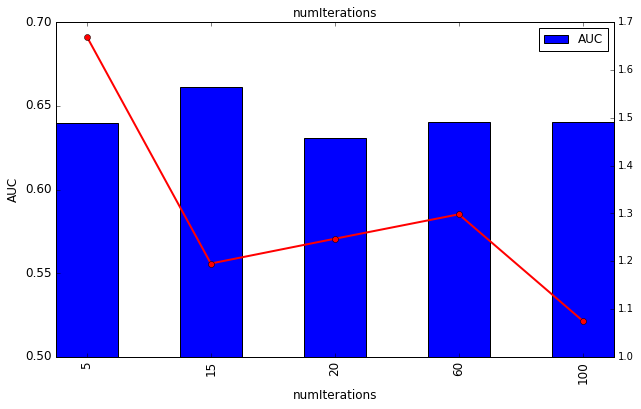

In [12]:
evalParameter(trainData, validationData, 
              "numIterations", numIterationsList=[5, 15, 20, 60, 100], 
              stepSizeList=[10], miniBatchFractionList=[1])

train evaluation(params):numIterations=100, stepSize=10, miniBatchFraction=1
==>required time:1.14191603661 ,AUC=0.685543108492
train evaluation(params):numIterations=100, stepSize=50, miniBatchFraction=1
==>required time:1.8562309742 ,AUC=0.593132687627
train evaluation(params):numIterations=100, stepSize=100, miniBatchFraction=1
==>required time:1.89332795143 ,AUC=0.611301308025
train evaluation(params):numIterations=100, stepSize=200, miniBatchFraction=1
==>required time:1.81189393997 ,AUC=0.580727755989


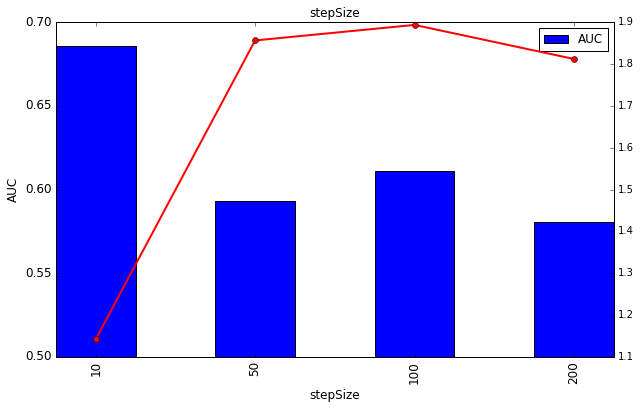

In [10]:
evalParameter(trainData, validationData, 
              "stepSize", numIterationsList=[100], 
              stepSizeList=[10 ,50 ,100 ,200], miniBatchFractionList=[1])

train evaluation(params):numIterations=100, stepSize=10, miniBatchFraction=0.5
==>required time:1.87715506554 ,AUC=0.685918687208
train evaluation(params):numIterations=100, stepSize=10, miniBatchFraction=0.8
==>required time:1.82978892326 ,AUC=0.688800531588
train evaluation(params):numIterations=100, stepSize=10, miniBatchFraction=1
==>required time:1.08583688736 ,AUC=0.685543108492


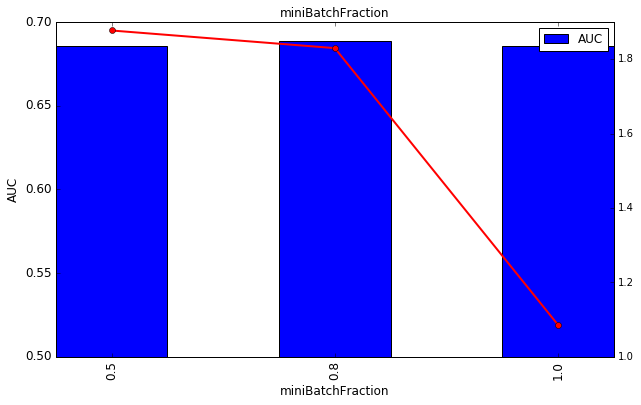

In [11]:
evalParameter(trainData, validationData, 
              "miniBatchFraction", numIterationsList=[100], 
              stepSizeList=[10], miniBatchFractionList=[0.5, 0.8, 1])

# Evaluation Process:multi-variables

In [13]:
def evalAllParameter(trainData, validationData, numIterationsList, stepSizeList, miniBatchFractionList):
    metrics = [trainEvaluateModel(trainData, validationData, numIterations, stepSize, miniBatchFraction)
               for numIterations in numIterationsList
               for stepSize in stepSizeList
               for miniBatchFraction in miniBatchFractionList]
    
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter = Smetrics[0]
    print("The best parameters: numIterations:" + str(bestParameter[2])+
                               ", stepSize:" + str(bestParameter[3])+
                               ", miniBatchFraction:" + str(bestParameter[4])+
                               "\n, AUC = " + str(bestParameter[0]) 
         ) 
    
    return bestParameter[5]

In [14]:
model = evalAllParameter(trainData, validationData, 
                         [5, 15, 25], [10, 50, 200], [0.5, 0.8, 1])

train evaluation(params):numIterations=5, stepSize=10, miniBatchFraction=0.5
==>required time:0.711043119431 ,AUC=0.642679195804
train evaluation(params):numIterations=5, stepSize=10, miniBatchFraction=0.8
==>required time:0.461963176727 ,AUC=0.638694638695
train evaluation(params):numIterations=5, stepSize=10, miniBatchFraction=1
==>required time:0.608309984207 ,AUC=0.639838286713
train evaluation(params):numIterations=5, stepSize=50, miniBatchFraction=0.5
==>required time:0.617454051971 ,AUC=0.5744245338
train evaluation(params):numIterations=5, stepSize=50, miniBatchFraction=0.8
==>required time:0.512947797775 ,AUC=0.570301573427
train evaluation(params):numIterations=5, stepSize=50, miniBatchFraction=1
==>required time:0.522212982178 ,AUC=0.572275641026
train evaluation(params):numIterations=5, stepSize=200, miniBatchFraction=0.5
==>required time:0.525760889053 ,AUC=0.556235431235
train evaluation(params):numIterations=5, stepSize=200, miniBatchFraction=0.8
==>required time:0.53006